### Import data & necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, probplot
from statsmodels.tsa.arima.model import ARIMA
from prophet.diagnostics import cross_validation, performance_metrics
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
logging.getLogger("prophet").setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

### Data Analysis

In [ ]:
#Path - Olivia
data = pd.read_csv('/content/drive/MyDrive/Quarter 2/Time Series and Forecasting/Time Series Analysis and Forecasting/new_gold_data.csv')

# Path - Amy
#data = pd.read_csv('/content/drive/My Drive/Time Series Analysis and Forecasting/new_gold_data.csv')

data.dropna(inplace=True)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data = data.sort_values(by='date', ascending=True)  # Sort chronologically
data.head()

,date,Gold Price,Oil Crude,US Dollar Index,S&P 500
0,2025-02-28,2836.800049,69.760002,107.610001,5954.500000
1,2025-02-27,2883.199951,70.349998,107.239998,5861.569824
2,2025-02-26,2916.800049,68.620003,106.419998,5956.060059


##### Time Series Plot

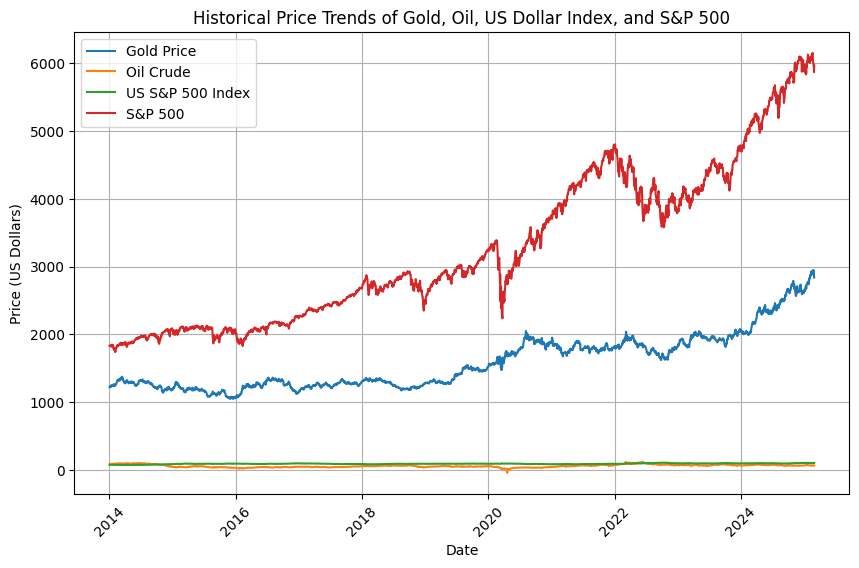

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Gold Price'], label='Gold Price')
plt.plot(data.index, data['Oil Crude'], label='Oil Crude')
plt.plot(data.index, data['US Dollar Index'], label='US S&P 500 Index')
plt.plot(data.index, data['S&P 500'], label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Price (US Dollars)')
plt.title('Historical Price Trends of Gold, Oil, US Dollar Index, and S&P 500')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()
plt.show()

##### Correlation Matrix

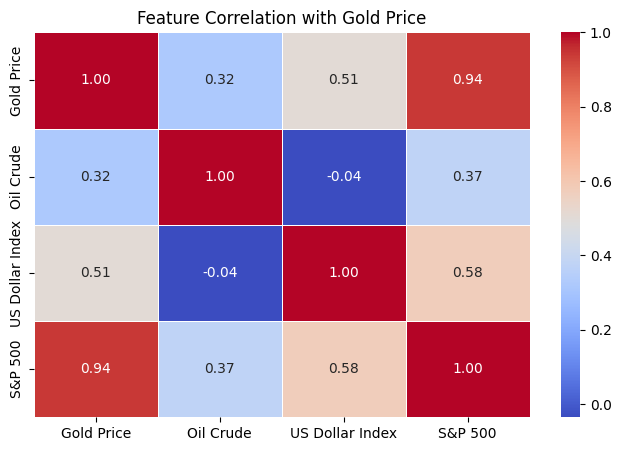

In [ ]:
corr_matrix = data.corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation with Gold Price")
plt.show()

**Interpretation:** Gold Price is strongly correlated to S&P 500 data.

### 1. Prophet Model

#### (1) Phophet model with no regressor

In [ ]:
prophet_model = Prophet(
    growth='linear',
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=1,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

In [ ]:
test_data = data.iloc[:int(0.2*len(data))]
train_data = data.iloc[int(0.2*len(data)):]
train_data.shape, test_data.shape

# Prepare the data for Prophet (ds, y)
df_prophet_train = train_data.reset_index()[['date', 'Gold Price']].dropna()
df_prophet_train = df_prophet_train.rename(columns={'date': 'ds', 'Gold Price': 'y'})
print("Length of the train data:", len(df_prophet_train))

df_prophet_test = test_data.reset_index()[['date', 'Gold Price']].dropna()
df_prophet_test = df_prophet_test.rename(columns={'date': 'ds', 'Gold Price': 'y'})
print("Length of the test data:", len(df_prophet_test))

Length of the train data: 2244
Length of the test data: 560


In [ ]:
prophet_model = Prophet()
prophet_model.fit(df_prophet_train)

# Forecast
forecast_test = prophet_model.predict(df_prophet_test)
forecast_train = prophet_model.predict(df_prophet_train)

Are the 'ds' in training columns identical? False
Are the 'ds' in training columns identical? False

Prediction result:
             ds        trend  yhat_lower   yhat_upper  trend_lower  \
559 2025-02-28  1720.916075  930.198957  2625.024108   867.893792   
558 2025-02-27  1720.972610  914.244541  2636.036474   870.481937   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
559  2567.863718       44.437617             44.437617             44.437617   
558  2565.712553       45.073982             45.073982             45.073982   

        weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
559  11.070027     11.070027     11.070027  33.367590     33.367590   
558  11.527973     11.527973     11.527973  33.546008     33.546008   

     yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
559     33.367590                   0.0                         0.0   
558     33.546008                   0.0                         0.0   

  

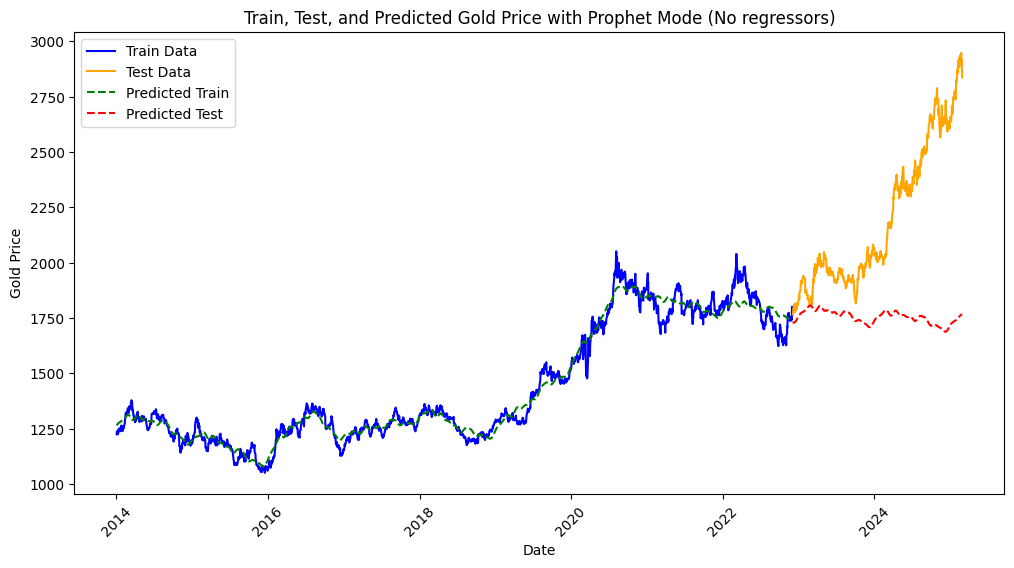

In [ ]:
# Plot Forecast
df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])
df_prophet_test['ds'] = pd.to_datetime(df_prophet_test['ds'])
forecast_train['ds'] = pd.to_datetime(forecast_train['ds'])
forecast_test['ds'] = pd.to_datetime(forecast_test['ds'])
plt.figure(figsize=(12, 6))
plt.plot(df_prophet_train['ds'], df_prophet_train['y'], label="Train Data", color='blue')
plt.plot(df_prophet_test['ds'], df_prophet_test['y'], label="Test Data", color='orange')
plt.plot(forecast_train['ds'], forecast_train['yhat'], label="Predicted Train", color='green', linestyle='dashed')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label="Predicted Test", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.title("Train, Test, and Predicted Gold Price with Prophet Mode (No regressors)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
y_true = df_prophet_test['y'].values
y_pred = forecast_test['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 444.8885
MSE: 291630.6460
RMSE: 540.0284
MAPE: 18.73%


#### (2) Prophet model with a regressors "Crude Oil Price" & "S&P500"

In [ ]:
prophet_model_with_regressors1 = Prophet(
    growth='logistic',
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=15,
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=False
)

In [ ]:
df_prophet_train1 = train_data.reset_index()[['date', 'Gold Price', 'Oil Crude','S&P 500','US Dollar Index']].dropna()
df_prophet_train1 = df_prophet_train1.rename(columns={'date': 'ds', 'Gold Price': 'y'})
df_prophet_test1 = test_data.reset_index()[['date', 'Gold Price', 'Oil Crude','S&P 500','US Dollar Index']].dropna()
df_prophet_test1 = df_prophet_test1.rename(columns={'date': 'ds', 'Gold Price': 'y'})
df_prophet_train1['cap'] = 70000
df_prophet_test1['cap'] = 70000

In [ ]:
# Fit the model with regressor: crude oil price and S&P500
prophet_model_with_regressors1.add_regressor('S&P 500')
prophet_model_with_regressors1.add_regressor('Oil Crude')
prophet_model_with_regressors1.fit(df_prophet_train1)
forecast_test1 = prophet_model_with_regressors1.predict(df_prophet_test1)
forecast_train1 = prophet_model_with_regressors1.predict(df_prophet_train1)

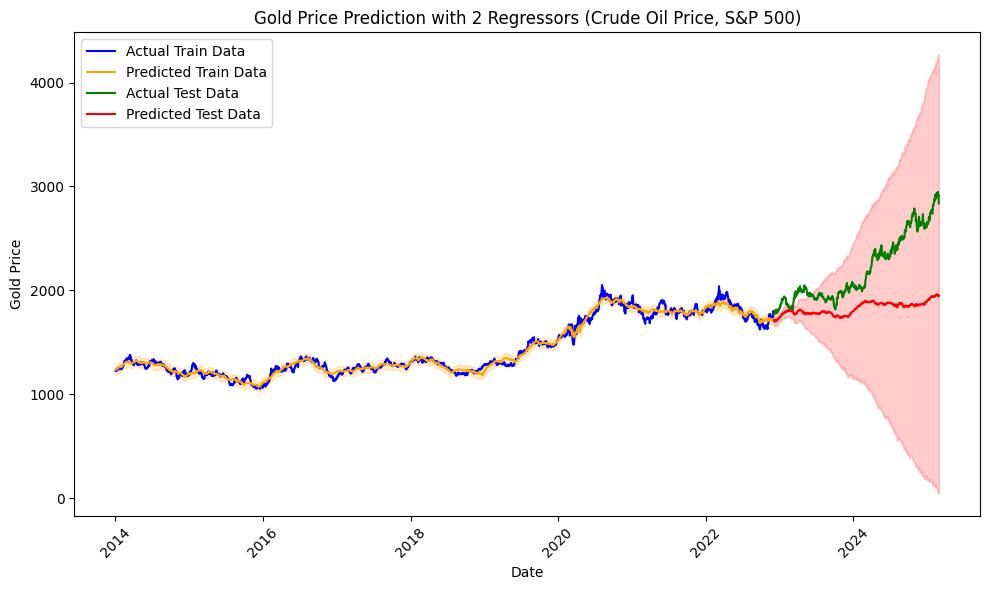

In [ ]:
# Plot the forecast
df_prophet_train1['ds'] = pd.to_datetime(df_prophet_train1['ds'])
df_prophet_test1['ds'] = pd.to_datetime(df_prophet_test1['ds'])
forecast_train1['ds'] = pd.to_datetime(forecast_train['ds'])
forecast_test1['ds'] = pd.to_datetime(forecast_test['ds'])
plt.figure(figsize=(10, 6))
plt.plot(df_prophet_train1['ds'], df_prophet_train1['y'], label='Actual Train Data', color='blue')
plt.plot(forecast_train1['ds'], forecast_train1['yhat'], label='Predicted Train Data', color='orange')
plt.fill_between(forecast_train1['ds'], forecast_train1['yhat_lower'], forecast_train1['yhat_upper'], color='orange', alpha=0.2)
plt.plot(df_prophet_test1['ds'], df_prophet_test1['y'], label='Actual Test Data', color='green')
plt.plot(forecast_test1['ds'], forecast_test1['yhat'], label='Predicted Test Data', color='red')
plt.fill_between(forecast_test1['ds'], forecast_test1['yhat_lower'], forecast_test1['yhat_upper'], color='red', alpha=0.2)
plt.title('Gold Price Prediction with 2 Regressors (Crude Oil Price, S&P 500)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Model Evaluation
y_true_r1 = df_prophet_test1['y'].values  # Actual values
y_pred_r1 = forecast_test1['yhat'].values  # Predicted values
mae = mean_absolute_error(y_true_r1, y_pred_r1)
mse = mean_squared_error(y_true_r1, y_pred_r1)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true_r1 - y_pred_r1) / y_true_r1)) * 100  # Percentage error
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 389.6903
MSE: 273785.2151
RMSE: 523.2449
MAPE: 15.93%


#### (3) Prophet model with regressors "Crude Oil Price", "S&P500" & "US Dollar Index"

In [ ]:
prophet_model_with_regressors2 = Prophet(
    growth='logistic',
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=15,  # Increase to capture seasonality better
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=False
)

In [ ]:
# Model with regressor crude oil price and S&P500 and US Dollar Index
prophet_model_with_regressors2.add_regressor('S&P 500')
prophet_model_with_regressors2.add_regressor('Oil Crude')
prophet_model_with_regressors2.add_regressor('US Dollar Index')
prophet_model_with_regressors2.fit(df_prophet_train1)
forecast_test2 = prophet_model_with_regressors2.predict(df_prophet_test1)
forecast_train2 = prophet_model_with_regressors2.predict(df_prophet_train1)

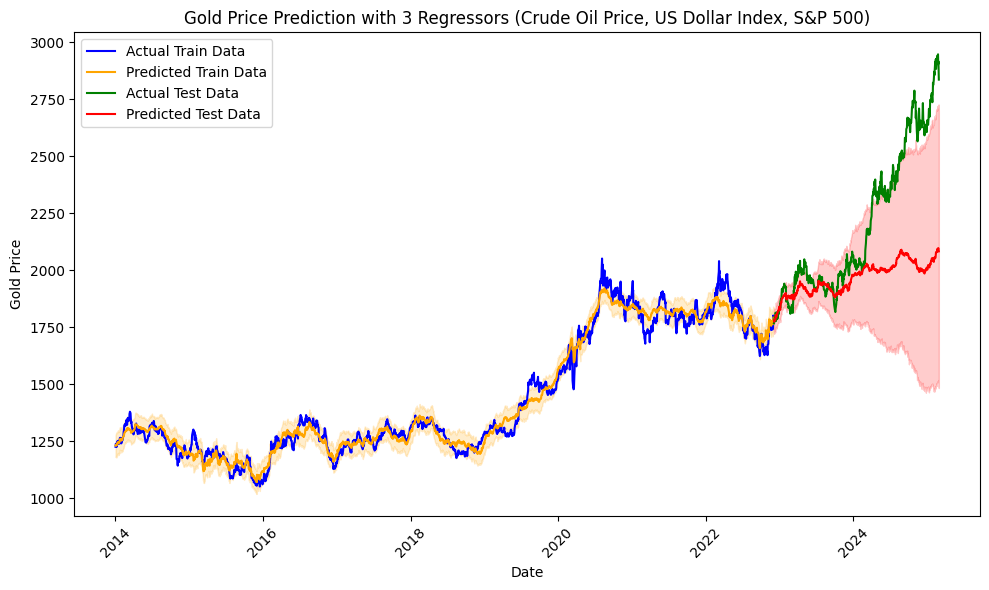

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df_prophet_train1['ds'], df_prophet_train1['y'], label='Actual Train Data', color='blue')
plt.plot(forecast_train2['ds'], forecast_train2['yhat'], label='Predicted Train Data', color='orange')
plt.fill_between(forecast_train2['ds'], forecast_train2['yhat_lower'], forecast_train2['yhat_upper'], color='orange', alpha=0.2)
plt.plot(df_prophet_test1['ds'], df_prophet_test1['y'], label='Actual Test Data', color='green')
plt.plot(forecast_test2['ds'], forecast_test2['yhat'], label='Predicted Test Data', color='red')
plt.fill_between(forecast_test2['ds'], forecast_test2['yhat_lower'], forecast_test2['yhat_upper'], color='red', alpha=0.2)
plt.title('Gold Price Prediction with 3 Regressors (Crude Oil Price, US Dollar Index, S&P 500)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Model Evaluation
y_true_r2 = df_prophet_test1['y'].values
y_pred_r2 = forecast_test2['yhat'].values
mae = mean_absolute_error(y_true_r2, y_pred_r2)
mse = mean_squared_error(y_true_r2, y_pred_r2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true_r2 - y_pred_r2) / y_true_r2)) * 100
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 326.8611
MSE: 199712.6363
RMSE: 446.8922
MAPE: 13.41%


### 2. LSTM Model

In [ ]:
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i: i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

time_steps = 10

#### (1) LSTM Model with Gole Price Only

In [ ]:
data_LSTM = data

target = ['Gold Price']
features = ['Oil Crude', 'US Dollar Index', 'S&P 500']
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

data_LSTM[target] = scaler_target.fit_transform(data_LSTM[target])
data_LSTM[features] = scaler_features.fit_transform(data_LSTM[features])
data_LSTM.tail()

,Gold Price,Oil Crude,US Dollar Index,S&P 500,log_gold_price,date
date,,,,,,
2025-02-24,1.000000,0.671481,0.785244,0.963451,1.000000,2025-02-24
2025-02-25,0.977123,0.660510,0.776952,0.957090,0.996341,2025-02-25
2025-02-26,0.983607,0.658588,0.780097,0.957274,0.997386,2025-02-26
2025-02-27,0.965895,0.669311,0.803546,0.935810,0.994513,2025-02-27
2025-02-28,0.941437,0.665654,0.814126,0.956920,0.990458,2025-02-28


In [ ]:
# Define train-test split (80% train, 20% test)
train_size = int(len(data_LSTM) * 0.8)
train, test = data_LSTM.iloc[:train_size], data_LSTM.iloc[train_size:]

X_train, y_train = create_sequences(train[target].values, train[target].values, time_steps)
X_test, y_test = create_sequences(test[target].values, test[target].values, time_steps)

In [ ]:
# Train LSTM Model
lstm_gold = build_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_gold.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))
y_train_pred = lstm_gold.predict(X_train)
y_test_pred = lstm_gold.predict(X_test)

y_train_pred = scaler_target.inverse_transform(y_train_pred)
y_test_pred = scaler_target.inverse_transform(y_test_pred)

y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_train = scaler_target.inverse_transform(y_train.reshape(-1, 1))

rss_train_gold = np.sum((y_train - y_train_pred) ** 2)
n_train_gold = len(y_train)

k_gold = np.sum([np.prod(v.shape) for v in lstm_gold.trainable_variables])

# AIC
aic_train_gold = 2 * k_gold + n_train_gold * np.log(rss_train_gold + 1e-8 / n_train_gold)

# Calculate Errors
mae_gold = mean_absolute_error(y_test, y_test_pred)
rmse_gold = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"LSTM (Gold Only) - MAE: {mae_gold}, RMSE: {rmse_gold}, AIC: {aic_train_gold}")

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0085 - val_loss: 6.4996e-04
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.0632e-04 - val_loss: 4.5643e-04
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.7431e-04 - val_loss: 5.6478e-04
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.9200e-04 - val_loss: 4.5941e-04
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.2152e-04 - val_loss: 6.4143e-04
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.0421e-04 - val_loss: 5.6572e-04
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.2131e-04 - val_loss: 9.0010e-04
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.5906e-04 - val_loss: 0.0016
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8580e-04 - val_loss: 0.0024
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.3306e-04 - val_loss: 9.8479e-04
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss:

#### (2) LSTM Model with Regressor 'S&P 500' (The most correlated feature)

In [ ]:
# Train-test split
X_train_reg1, y_train_reg1 = create_sequences(train[['S&P 500'] + target].values, train[target].values, time_steps)
X_test_reg1, y_test_reg1 = create_sequences(test[['S&P 500'] + target].values, test[target].values, time_steps)

In [ ]:
# Train LSTM Model
lstm_reg1 = build_lstm_model((X_train_reg1.shape[1], X_train_reg1.shape[2]))
lstm_reg1.fit(X_train_reg1, y_train_reg1, epochs=20, batch_size=16, validation_data=(X_test_reg1, y_test_reg1))

y_train_pred_reg1 = lstm_reg1.predict(X_train_reg1)
y_test_pred_reg1 = lstm_reg1.predict(X_test_reg1)

y_train_pred_reg1 = scaler_target.inverse_transform(y_train_pred_reg1)
y_test_pred_reg1 = scaler_target.inverse_transform(y_test_pred_reg1)

y_test_reg1 = scaler_target.inverse_transform(y_test_reg1.reshape(-1, 1))
y_train_reg1 = scaler_target.inverse_transform(y_train_reg1.reshape(-1, 1))

rss_train_reg1 = np.sum((y_train_reg1 - y_train_pred_reg1) ** 2)
n_train_reg1 = len(y_train_reg1)

k_reg1 = np.sum([np.prod(v.shape) for v in lstm_reg1.trainable_variables])

#AIC
aic_train_reg1 = 2 * k_reg1 + n_train_reg1 * np.log(rss_train_reg1 + 1e-8 / n_train_reg1)

# Calculate Errors
mae_reg1 = mean_absolute_error(y_test_reg1, y_test_pred_reg1)
rmse_reg1 = np.sqrt(mean_squared_error(y_test_reg1, y_test_pred_reg1))
print(f"LSTM (With 1 Regressor 'S&P500') - MAE: {mae_reg1}, RMSE: {rmse_reg1}, AIC: {aic_train_reg1}")

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0100 - val_loss: 7.6720e-04
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 8.8457e-04 - val_loss: 9.7609e-04
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.6968e-04 - val_loss: 0.0018
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.8001e-04 - val_loss: 0.0030
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 5.6802e-04 - val_loss: 0.0023
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.5921e-04 - val_loss: 0.0023
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.1993e-04 - val_loss: 0.0017
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.7804e-04 - val_loss: 0.0029
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.9630e-04 - val_loss: 0.0022
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.6385e-04 - val_loss: 0.0028
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.8320e-04 - val_loss: 

#### (3) LSTM Model with Regressor 'S&P 500, 'Oil Crude', and 'US Dollar'

In [ ]:
X_train_reg, y_train_reg = create_sequences(train[features + target].values, train[target].values, time_steps)
X_test_reg, y_test_reg = create_sequences(test[features + target].values, test[target].values, time_steps)

In [ ]:
# Train LSTM Model with Regressors
lstm_reg2 = build_lstm_model((X_train_reg.shape[1], X_train_reg.shape[2]))
lstm_reg2.fit(X_train_reg, y_train_reg, epochs=20, batch_size=16, validation_data=(X_test_reg, y_test_reg))

y_train_pred_reg = lstm_reg2.predict(X_train_reg)
y_test_pred_reg = lstm_reg2.predict(X_test_reg)

y_train_pred_reg = scaler_target.inverse_transform(y_train_pred_reg)
y_test_pred_reg = scaler_target.inverse_transform(y_test_pred_reg)

y_test_reg = scaler_target.inverse_transform(y_test_reg.reshape(-1, 1))
y_train_reg = scaler_target.inverse_transform(y_train_reg.reshape(-1, 1))

rss_train_reg = np.sum((y_train_reg - y_train_pred_reg) ** 2)
n_train_reg = len(y_train_reg)

k_reg = np.sum([np.prod(v.shape) for v in lstm_reg2.trainable_variables])

#AIC
aic_train_reg = 2 * k_reg + n_train_reg * np.log(rss_train_reg + 1e-8 / n_train_reg)

# Calculate Errors
mae_reg = mean_absolute_error(y_test_reg, y_test_pred_reg)
rmse_reg = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg))
print(f"LSTM (With 1 Regressor 'S&P500') - MAE: {mae_reg}, RMSE: {rmse_reg}, AIC: {aic_train_reg}")

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0115 - val_loss: 0.0018
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012 - val_loss: 6.2856e-04
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 9.2494e-04 - val_loss: 0.0051
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.7624e-04 - val_loss: 9.9810e-04
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.1144e-04 - val_loss: 0.0013
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.6847e-04 - val_loss: 0.0013
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.6793e-04 - val_loss: 0.0040
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.2018e-04 - val_loss: 0.0014
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 5.3543e-04 - val_loss: 8.7901e-04
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.1601e-04 - val_loss: 0.0013
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.6299e-04 - val_loss: 

#### (4) Results & Evaluation

In [ ]:
print(f"LSTM with Gold Price Only - MAE: {mae_gold}, RMSE: {rmse_gold}")
print(f"LSTM (With 1 Regressor) - MAE: {mae_reg1}, RMSE: {rmse_reg1}")
print(f"LSTM (With 3 Regressors) - MAE: {mae_reg}, RMSE: {rmse_reg}")

LSTM with Gold Price Only - MAE: 0.021059514345766327, RMSE: 0.02827076308505137
LSTM (With 1 Regressor) - MAE: 0.02931781359143047, RMSE: 0.03891183459275419
LSTM (With 3 Regressors) - MAE: 0.021669400849417205, RMSE: 0.029382276197504522


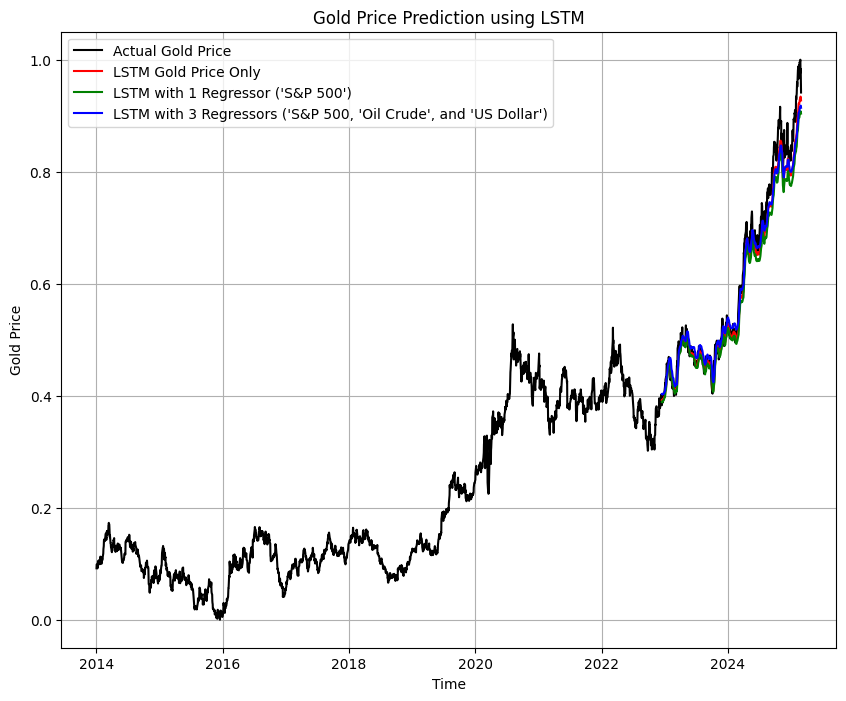

In [ ]:
# Plot Results
data['date'] = pd.to_datetime(data.index)
test_dates = data.iloc[train_size + time_steps:]['date']
plt.figure(figsize=(10, 8))
plt.plot(data['date'], data['Gold Price'], label="Actual Gold Price", color='black')
plt.plot(test_dates, y_test_pred, label="LSTM Gold Price Only", color='red')
plt.plot(test_dates, y_test_pred_reg1, label="LSTM with 1 Regressor ('S&P 500')", color='green')
plt.plot(test_dates, y_test_pred_reg, label="LSTM with 3 Regressors ('S&P 500, 'Oil Crude', and 'US Dollar')", color='blue')
plt.title("Gold Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Gold Price")
plt.legend()
plt.grid()
plt.show()

### 3. Neural Network

In [ ]:
data_MLP = data

target = ['Gold Price']
features = ['Oil Crude', 'US Dollar Index', 'S&P 500']

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

data_MLP[target] = scaler_target.fit_transform(data_MLP[target])
data_MLP[features] = scaler_features.fit_transform(data_MLP[features])

data_MLP.head()

,Gold Price,Oil Crude,US Dollar Index,S&P 500,log_gold_price,date
date,,,,,,
2014-01-02,0.091824,0.824831,0.042608,0.020464,0.622430,2014-01-02
2014-01-03,0.098888,0.815657,0.047183,0.020326,0.634148,2014-01-03
2014-01-06,0.098572,0.812372,0.043180,0.019281,0.633642,2014-01-06
2014-01-07,0.094144,0.813860,0.048327,0.021805,0.626374,2014-01-07
2014-01-08,0.091983,0.805554,0.054332,0.021716,0.622702,2014-01-08


In [ ]:
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i: i + time_steps].flatten())  # Flatten for MLP
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps=10

In [ ]:
def build_mlp_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

#### (1) MLP Model with Gole Price Only

In [ ]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

X_train_mlp1, y_train_mlp1 = create_sequences(train[target].values, train[target].values, time_steps)
X_test_mlp1, y_test_mlp1 = create_sequences(test[target].values, test[target].values, time_steps)

mlp_model = build_mlp_model((X_train_mlp1.shape[1],))  # Input shape is flattened

mlp_model.fit(X_train_mlp1, y_train_mlp1, epochs=20, batch_size=16, validation_data=(X_test_mlp1, y_test_mlp1))

y_pred_mlp1 = mlp_model.predict(X_test_mlp1)

y_pred_mlp1 = scaler_target.inverse_transform(y_pred_mlp1)
y_test_mlp1 = scaler_target.inverse_transform(y_test_mlp1.reshape(-1, 1))

# Evaluation
mae_mlp1 = mean_absolute_error(y_test_mlp1, y_pred_mlp1)
rmse_mlp1 = np.sqrt(mean_squared_error(y_test_mlp1, y_pred_mlp1))

y_train_pred_mlp1 = mlp_model.predict(X_train_mlp1)

y_train_pred_mlp1 = scaler_target.inverse_transform(y_train_pred_mlp1)
y_train_mlp1 = scaler_target.inverse_transform(y_train_mlp1.reshape(-1, 1))

rss_train_mlp1 = np.sum((y_train_mlp1 - y_train_pred_mlp1) ** 2)

n_train_mlp1 = len(y_train_mlp1)

k_mlp1 = np.sum([np.prod(v.shape) for v in mlp_model.trainable_variables])

# Compute AIC
aic_mlp1 = 2 * k_mlp1 + n_train_mlp1 * np.log(rss_train_mlp1 / n_train_mlp1)

print(f"MLP Model - MAE: {mae_mlp1}, RMSE: {rmse_mlp1}, AIC (Training Data): {aic_mlp1}")

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0028 - val_loss: 0.0122
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0550e-04 - val_loss: 0.0105
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1277e-04 - val_loss: 0.0148
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5814e-04 - val_loss: 0.0138
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8174e-04 - val_loss: 0.0165
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8390e-04 - val_loss: 0.0149
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6756e-04 - val_loss: 0.0122
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1076e-04 - val_loss: 0.0132
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0626e-04 - val_loss: 0.0114
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0401e-04 - val_loss: 0.0193
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9937e-04 - val_loss: 0.0163
Epoch 12/20


#### (2) MLP Model with Regressor 'S&P 500' (The most correlated feature)

In [ ]:
# Train-test split
X_train_mlp2, y_train_mlp2 = create_sequences(train[['Gold Price'] + target].values, train[target].values, time_steps)
X_test_mlp2, y_test_mlp2 = create_sequences(test[['Gold Price'] + target].values, test[target].values, time_steps)

mlp_model = build_mlp_model((X_train_mlp2.shape[1],))

mlp_model.fit(X_train_mlp2, y_train_mlp2, epochs=20, batch_size=16, validation_data=(X_test_mlp2, y_test_mlp2))

y_pred_mlp2 = mlp_model.predict(X_test_mlp2)

y_pred_mlp2 = scaler_target.inverse_transform(y_pred_mlp2)
y_test_mlp2 = scaler_target.inverse_transform(y_test_mlp2.reshape(-1, 1))

# Evaluation
mae_mlp2 = mean_absolute_error(y_test_mlp2, y_pred_mlp2)
rmse_mlp2 = np.sqrt(mean_squared_error(y_test_mlp2, y_pred_mlp2))

# Make predictions on training data
y_train_pred_mlp2 = mlp_model.predict(X_train_mlp2)

# Inverse transform predictions
y_train_pred_mlp2 = scaler_target.inverse_transform(y_train_pred_mlp2)
y_train_mlp2 = scaler_target.inverse_transform(y_train_mlp2.reshape(-1, 1))

# Compute Residual Sum of Squares (RSS)
rss_train_mlp2 = np.sum((y_train_mlp2 - y_train_pred_mlp2) ** 2)

# Number of train samples
n_train_mlp2 = len(y_train_mlp2)

# Number of parameters (trainable weights & biases)
k_mlp2 = np.sum([np.prod(v.shape) for v in mlp_model.trainable_variables])

# Compute AIC
aic_mlp2 = 2 * k_mlp2 + n_train_mlp2 * np.log(rss_train_mlp2 / n_train_mlp2)

print(f"MLP Model - MAE: {mae_mlp2}, RMSE: {rmse_mlp2}, AIC (Training Data): {aic_mlp2}")

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0071 - val_loss: 0.0086
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9286e-04 - val_loss: 0.0123
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2505e-04 - val_loss: 0.0098
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3609e-04 - val_loss: 0.0073
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2849e-04 - val_loss: 0.0114
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6136e-04 - val_loss: 0.0141
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8514e-04 - val_loss: 0.0087
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6903e-04 - val_loss: 0.0105
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3085e-04 - val_loss: 0.0107
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8715e-04 - val_loss: 0.0083
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0715e-04 - val_loss: 0.0171
Epoch 12/20


#### (3) LSTM Model with Regressor 'S&P 500, 'Oil Crude', and 'US Dollar'

In [ ]:
# Train-test split
X_train_mlp3, y_train_mlp3 = create_sequences(train[features + target].values, train[target].values, time_steps)
X_test_mlp3, y_test_mlp3 = create_sequences(test[features + target].values, test[target].values, time_steps)

# Fit the model
mlp_model = build_mlp_model((X_train_mlp3.shape[1],))  # Input shape is flattened

mlp_model.fit(X_train_mlp3, y_train_mlp3, epochs=20, batch_size=16, validation_data=(X_test_mlp3, y_test_mlp3))

# Make predictions
y_pred_mlp3 = mlp_model.predict(X_test_mlp3)

y_pred_mlp3 = scaler_target.inverse_transform(y_pred_mlp3)
y_test_mlp3 = scaler_target.inverse_transform(y_test_mlp3.reshape(-1, 1))

# Evaluation
mae_mlp3 = mean_absolute_error(y_test_mlp3, y_pred_mlp3)
rmse_mlp3 = np.sqrt(mean_squared_error(y_test_mlp3, y_pred_mlp3))

# Make predictions on training data
y_train_pred_mlp3 = mlp_model.predict(X_train_mlp3)

# Inverse transform predictions
y_train_pred_mlp3 = scaler_target.inverse_transform(y_train_pred_mlp3)
y_train_mlp3 = scaler_target.inverse_transform(y_train_mlp3.reshape(-1, 1))

# Compute Residual Sum of Squares (RSS)
rss_train_mlp3 = np.sum((y_train_mlp3 - y_train_pred_mlp3) ** 2)

# Number of train samples
n_train_mlp3 = len(y_train_mlp3)

# Number of parameters (trainable weights & biases)
k_mlp3 = np.sum([np.prod(v.shape) for v in mlp_model.trainable_variables])

# Compute AIC
aic_mlp3 = 2 * k_mlp3 + n_train_mlp3 * np.log(rss_train_mlp3 / n_train_mlp3)

print(f"MLP Model - MAE: {mae_mlp3}, RMSE: {rmse_mlp3}, AIC (Training Data): {aic_mlp3}")

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0238 - val_loss: 0.0030
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024 - val_loss: 0.0051
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0099
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - val_loss: 0.0066
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.9678e-04 - val_loss: 0.0051
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8849e-04 - val_loss: 0.0085
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.0035e-04 - val_loss: 0.0076
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3000e-04 - val_loss: 0.0055
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.4282e-04 - val_loss: 0.0090
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6410e-04 - val_loss: 0.0089
Epoch 12/20
140/140 ━━━━━━━━

#### (4) Results & Evaluation

In [ ]:
print(f"MLP with Gold Price Only - MAE: {mae_mlp1}, RMSE: {rmse_mlp1}")
print(f"MLP (With 1 Regressor) - MAE: {mae_mlp2}, RMSE: {rmse_mlp2}")
print(f"MLP (With 3 Regressors) - MAE: {mae_mlp3}, RMSE: {rmse_mlp3}")

MLP with Gold Price Only - MAE: 0.11526628739997744, RMSE: 0.12024746930163313
MLP (With 1 Regressor) - MAE: 0.1149175713452099, RMSE: 0.12049275266249655
MLP (With 3 Regressors) - MAE: 0.09566449995442791, RMSE: 0.1002912770460912


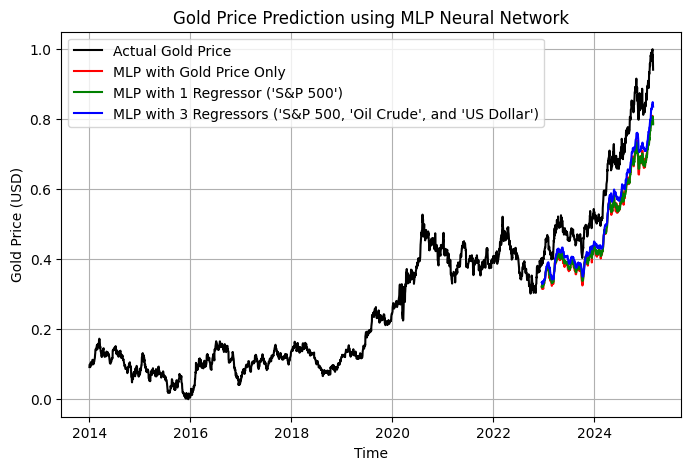

In [ ]:
data['date'] = pd.to_datetime(data.index)
test_dates = data.iloc[train_size + time_steps:]['date']
plt.figure(figsize=(8, 5))
plt.plot(data['date'], data['Gold Price'], label="Actual Gold Price", color='black')
plt.plot(test_dates, y_pred_mlp1, label="MLP with Gold Price Only", color='red')
plt.plot(test_dates, y_pred_mlp2, label="MLP with 1 Regressor ('S&P 500')", color='green')
plt.plot(test_dates, y_pred_mlp3, label="MLP with 3 Regressors ('S&P 500, 'Oil Crude', and 'US Dollar')", color='blue')
plt.title("Gold Price Prediction using MLP Neural Network")
plt.xlabel("Time")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.grid()
plt.show()